### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [ ]:
#Todo
#Remove punctuation
#Use embedding that represents headslines
#Tokenizer with special token

In [1]:
# You will need to download any word embeddings required for your code, e.g.:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

--2021-02-23 16:18:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-23 16:18:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-23 16:18:46--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
! pip install transformers

     |████████████████████████████████| 1.8MB 4.1MB/s 
     |████████████████████████████████| 890kB 11.6MB/s 
     |████████████████████████████████| 3.2MB 21.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=056aaec63785893e4e3b5570f23eddb0b09fdb9aadebb01c9c2cae13f0c8cb27
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import spacy
import nltk
nltk.download('wordnet')
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from spacy.tokenizer import Tokenizer
import re
import pdb
import random
import csv
import tqdm
from tqdm import tqdm
import multiprocessing
import pickle
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
import os


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
!nvidia-smi

Sun Feb 21 12:48:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [5]:
# Load data
%mkdir ./data
%cd ./data
import os

if not os.path.isfile('train.csv'): 
  !wget -O train.csv https://www.dropbox.com/s/utcewlslgwm278m/train.csv?dl=0
if not os.path.isfile('dev.csv'): 
  !wget -O dev.csv https://www.dropbox.com/s/0bpqmpb009ay717/dev.csv?dl=0
if not os.path.isfile('extra_train.csv'): 
  !wget -O extra_train.csv https://www.dropbox.com/s/6bptu62w4uvhtkf/extra_train_data-3.csv?dl=0

%cd ..

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/dev.csv')
extra_train = pd.read_csv('./data/extra_train.csv')


/content/data
--2021-02-23 16:26:25--  https://www.dropbox.com/s/utcewlslgwm278m/train.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/utcewlslgwm278m/train.csv [following]
--2021-02-23 16:26:25--  https://www.dropbox.com/s/raw/utcewlslgwm278m/train.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce96a6b682f9c30b4c3f9fbc5df.dl.dropboxusercontent.com/cd/0/inline/BJd-vzWpshzwxB7qrCb7d4qSJfvOo9FTRdEmBnkTICX8o5v1TD9MLQD5f6ROGPvbQDuTzVjVfjTA-mozh1UXIFUu22c76grVqQc_J7vwYkQCxTOwWBj0mSAoM5RJVffvmf8/file# [following]
--2021-02-23 16:26:26--  https://uce96a6b682f9c30b4c3f9fbc5df.dl.dropboxusercontent.com/cd/0/inline/BJd-vzWpshzwxB7qrCb7d4qSJfvOo9FTRdEmBnkTICX8o5v1TD9MLQD5f6ROGPvbQDuTzVjVfjTA-mozh1UXIFUu22c76grVqQ

In [6]:
train_df = pd.concat([train_df, extra_train], ignore_index=True)

In [ ]:
#Kevin
%cd /content/drive/MyDrive/Colab Notebooks/NLP_Coursework/ic_nlp_cw
train_df = pd.read_csv('./task-1/train.csv')
test_df = pd.read_csv('./task-1/dev.csv')
extra_train = pd.read_csv('./extra_train_data-3.csv')

/content/drive/MyDrive/Colab Notebooks/NLP_Coursework/ic_nlp_cw


### Data PreProcessing

In [7]:
def get_grade_list(grades):
  grade_list = []
  for i, grade in enumerate(grades):
    list_grade = list(str(grade))
    grade_list.append(list(map(int, list_grade)))
  return grade_list
    

In [8]:
 def add_columns_to_data(train_df, test_df):   
    #instead of having two inputs out of preprocessing, edit the dataset, and add in columns which we can use as inputs
    #we can also add an 'old' field which contains the original word 
    train_df['old'] = train_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)
    test_df['old'] = test_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)

    #first we add a field to the data which contains the edited headline
    train_df['edited'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],x['edit'] ) ,axis=1)
    test_df['edited'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], x['edit'] ) ,axis=1)

    train_df['original'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], x['old']) ,axis=1)
    test_df['original'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], x['old']),axis=1)

    grades = train_df["grades"].tolist()
    grade_lists = get_grade_list(grades)
    vars = [np.var(grade) for grade in grade_lists]
    train_df["variance"] = vars

    return train_df, test_df

In [9]:
train_df, test_df = add_columns_to_data(train_df, test_df)

In [10]:
# Number of epochs
epochs = 80

# Proportion of training data for train compared to dev
train_proportion = 0.8

### Creating Vocab and Tokenized Corpus

In [11]:
# To create our vocab

def custom_tokenizer(nlp):
    
    replacement_re = re.compile(r'^<*/>') #do not split replacement format
    prefix_re = re.compile(r'''^[\[\("]''')
    suffix_re = re.compile(r''',[\]\)"']$''')
    infix_re = re.compile(r'''[-\,.~]''')
    
    
    return Tokenizer(nlp.vocab,
                     token_match = replacement_re.match,
                     prefix_search=prefix_re.search,
                     suffix_search=suffix_re.search,
                     infix_finditer = infix_re.finditer  
                    )



def preprocessor(data,edits):
    """
    Creating a corpus of all the tokens used
    """
    punctuation = "\":\.,"
    nlp = spacy.load("en_core_web_sm")
    nlp.tokenizer = custom_tokenizer(nlp)
    
    tokenized_corpus_1= [] # Let us put the tokenized corpus in a list
    tokenized_corpus_2= []
    
    
    for i, sentence in enumerate(data):

        sentence = sentence.lower()
        tokenized_sentence_1 = []
        tokenized_sentence_2 = []

        for token in nlp(sentence): # simplest split is

            if token.text in punctuation:
                continue
            else:
                
                if token.text[0] == '<':
                    tokenized_sentence_1.append("???")
                    tokenized_sentence_2.append("???")
                    
                    tokenized_sentence_2.append(edits[i])

                    
                    tokenized_sentence_1.append(token.text[1:-2])
                else:
                    tokenized_sentence_2.append(token.text)
                
                    tokenized_sentence_1.append(token.text)


        tokenized_corpus_1.append(tokenized_sentence_1)
        tokenized_corpus_2.append(tokenized_sentence_2)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus_1:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)
    
    for token in edits:
        
        if token not in vocabulary:
            
            vocabulary.append(token)

    return vocabulary, tokenized_corpus_1, tokenized_corpus_2

In [12]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = train_df['original']
test_data = test_df['original']

# Creating word vectors
#training_vocab, training_tokenized_corpus = create_vocab(training_data)
#test_vocab, test_tokenized_corpus = create_vocab(test_data)
training_vocab, training_tokenized_corpus_1,training_tokenized_corpus_2=  preprocessor(training_data,train_df['edit'])
test_vocab, test_tokenized_corpus_1,test_tokenized_corpus_2=  preprocessor(test_data,test_df['edit'])

#print("Vocabulary individual creation - done")

# Creating joint vocab from test and train:
#joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))
joint_vocab, joint_tokenized_corpus_1,joint_tokenized_corpus_2 = preprocessor(pd.concat([training_data, test_data]),pd.concat([train_df['edit'],test_df['edit']],ignore_index = True))

print("Vocabulary joined creation - done")



print("Vocab created.")

Vocabulary joined creation - done
Vocab created.


In [13]:
# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

#Add special character -> embedding vector of ones 
wvecs.append(np.ones(100))

# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 1 #zero padding
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)





In [14]:
word2idx['<unk>'] = 1
idx2word[1] = '<unk>'
mean = np.mean(wvecs, axis=0) # initialize unknown token as mean
#wvecs = np.vstack((wvecs, mean))
wvecs[0] = mean


In [15]:


vectorized_seqs_1 = [[word2idx[tok] if tok in word2idx else word2idx['<unk>'] for tok in seq] for seq in training_tokenized_corpus_1]
vectorized_seqs_2 = [[word2idx[tok] if tok in word2idx else word2idx['<unk>'] for tok in seq] for seq in training_tokenized_corpus_2]


# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_1 = [x if len(x) > 0 else [0] for x in vectorized_seqs_1]
vectorized_seqs_2 = [x if len(x) > 0 else [0] for x in vectorized_seqs_2]



### Training for BILSTM

In [16]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, bert=False):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    train_losses = np.zeros(number_epoch)
    valid_losses = np.zeros(number_epoch)
    train_rmses = []
    valid_rmses = []
    print("Training model.")

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:
            optimizer.zero_grad()

            feature, target = batch
            feature_1= feature[0].to(device)
            feature_2 = feature[1].to(device)
            target = target.to(device)
            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden_1 = model.init_hidden()
            model.hidden_2 = model.init_hidden()

            feature = (feature_1, feature_2)
            predictions = model(feature).squeeze(1)
            
            loss = loss_fn(predictions, target)
                        
            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy()) 
            
            loss.backward(retain_graph=True)
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, preds, targs = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        train_losses[epoch-1] = epoch_loss
        valid_losses[epoch-1] = valid_loss
        train_rmses.append(epoch_mse**0.5)
        valid_rmses.append(valid_mse**0.5)
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')
    return train_losses, valid_losses, preds, targs, train_rmses, valid_rmses

In [17]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0



    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch
            feature_1= feature[0].to(device)
            feature_2 = feature[1].to(device)
            target = target.to(device)

            feature = (feature_1, feature_2)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden_1 = model.init_hidden()
            model.hidden_2 = model.init_hidden()

            predictions = model(feature).squeeze(1)
            #predictions.requires_grad = True
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [18]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [19]:

def collate_fn_padd(batch):
    
    #We add padding to our minibatches and create tensors for our model
    

    batch_labels = [l for f, g, l in batch]
    batch_features = [(f,g) for f, g, l in batch]
    

    batch_features_len = [len(f) for f, g, l in batch]


    seq_tensor_1 = torch.zeros((len(batch), 50)).long()
    seq_tensor_2 = torch.zeros((len(batch), 50)).long()

    
    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor_1[idx, :seqlen] = torch.LongTensor(seq[0])
        seq_tensor_2[idx, :seqlen] = torch.LongTensor(seq[1])
    batch_labels = torch.FloatTensor(batch_labels)
    

    return (seq_tensor_1, seq_tensor_2), batch_labels


class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]
    
class Task1Dataset_double(Dataset):

    def __init__(self, train_data_1,train_data_2, labels):
        self.x_train_1 = train_data_1
        self.x_train_2 = train_data_2
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train_1[item],self.x_train_2[item], self.y_train[item]    


In [20]:
class BiLSTM_double(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM_double, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm_1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.lstm_2 = nn.LSTM(embedding_dim,hidden_dim, bidirectional = True)

        # The linear layer that maps from hidden state space to tag space
        self.fc = nn.Linear(2*55*100, hidden_dim*2)
        #self.fc2 = nn.Linear(hidden_dim*2, hidden_dim//2)
        #self.fc3 = nn.Linear(hidden_dim//2, hidden_dim//4)

        self.hidden_1 = self.init_hidden()
        self.hidden_2 = self.init_hidden()
        self.hidden2label = nn.Linear(hidden_dim*2, 1)


        self.d1 = nn.Dropout(0.5)
        self.d2 = nn.Dropout(0.5)
        self.d3 = nn.Dropout(0.5)
        #self.d4 = nn.Dropout(0.3)
        #self.d5 = nn.Dropout(0.3)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        
        return torch.zeros(2, self.batch_size, self.hidden_dim, requires_grad = True).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim, requires_grad = True).to(self.device)

    def forward(self, sentence):
        self.embedded_1 = self.embedding(sentence[0])
        self.embedded_1 = self.embedded_1.permute(1, 0, 2) #Needed for LSTMs

        self.embedded_2 = self.embedding(sentence[1])
        self.embedded_2 = self.embedded_2.permute(1, 0, 2) #Needed for LSTMs

        #lstm_out : (seq_len,batch_size,num_directions (2) * hidden_size (50))
        #hidden : (num_layers * num_directions, batch_size,hidden_size)
        lstm_out_1, self.hidden_1 = self.lstm_1(
            self.embedded_1.view(len(self.embedded_1), self.batch_size, self.embedding_dim), self.hidden_1)
        
        lstm_out_1 = F.leaky_relu(self.d1(lstm_out_1))

        lstm_out_2, self.hidden_2 = self.lstm_2(
            self.embedded_2.view(len(self.embedded_2), self.batch_size, self.embedding_dim), self.hidden_2)
        
        lstm_out_2 = F.leaky_relu(self.d2(lstm_out_2))
        
        #out : (1)
        lstm_out_1 = lstm_out_1.permute(1,0,2)
        lstm_out_2 = lstm_out_2.permute(1,0,2)

        out1 = self.fc(torch.cat((lstm_out_1.reshape(self.batch_size, -1),lstm_out_2.reshape(self.batch_size, -1)), dim = 1))
        out1 = F.leaky_relu(self.d3(out1))

        #out2 = self.fc2(out1)
        #out2 = F.leaky_relu(self.d4(out2))

        #out3 = self.fc3(out2)
        #out3 = F.leaky_relu(self.d5(out3))

        out = self.hidden2label(out1)
        return out

In [21]:

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = wvecs.shape[1]

BATCH_SIZE = 128

model = BiLSTM_double(EMBEDDING_DIM, 55, INPUT_DIM, BATCH_SIZE, device)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(params)
#print("Total number of parameters is: {​​}​​".format(params))

print(model)

print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
#x = np.concatenate((wvecs,wvecs),axis=1)
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))



2985381
BiLSTM_double(
  (embedding): Embedding(16370, 100, padding_idx=0)
  (lstm_1): LSTM(100, 55, bidirectional=True)
  (lstm_2): LSTM(100, 55, bidirectional=True)
  (fc): Linear(in_features=11000, out_features=110, bias=True)
  (hidden2label): Linear(in_features=110, out_features=1, bias=True)
  (d1): Dropout(p=0.5, inplace=False)
  (d2): Dropout(p=0.5, inplace=False)
  (d3): Dropout(p=0.5, inplace=False)
)
Model initialised.


tensor([[ 0.0045,  0.0884,  0.1403,  ..., -0.0549,  0.1601,  0.0868],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        [-0.1529, -0.2428,  0.8984,  ..., -0.5910,  1.0039,  0.2066],
        ...,
        [ 0.0068,  0.0145, -0.3016,  ...,  0.5548, -0.1785,  0.0685],
        [ 0.1981, -0.0991, -0.2745,  ...,  0.1796, -0.3175,  0.1357],
        [ 0.1318,  0.0111, -0.1804,  ...,  0.1664, -0.2256,  0.3588]],
       device='cuda:0')

In [22]:
import matplotlib.pyplot as plt
def plot(train_losses,valid_losses,num_epochs):
  epochs = list(range(num_epochs))
  plt.plot(epochs,train_losses, label='train')
  plt.plot(epochs,valid_losses, label='valid')
  plt.legend()
  plt.show()


In [23]:

feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['meanGrade'])
#train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['variance'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))
####Shuffle might need to be true. Check later
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.9)


Dataloaders created.


### Predicting the Variance

Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.40 | Train MSE: 0.40 | Train RMSE: 0.63 |         Val. Loss: 0.29 | Val. MSE: 0.29 |  Val. RMSE: 0.54 |
| Epoch: 02 | Train Loss: 0.24 | Train MSE: 0.24 | Train RMSE: 0.49 |         Val. Loss: 0.20 | Val. MSE: 0.20 |  Val. RMSE: 0.45 |
| Epoch: 03 | Train Loss: 0.20 | Train MSE: 0.20 | Train RMSE: 0.44 |         Val. Loss: 0.18 | Val. MSE: 0.18 |  Val. RMSE: 0.43 |
| Epoch: 04 | Train Loss: 0.19 | Train MSE: 0.19 | Train RMSE: 0.43 |         Val. Loss: 0.18 | Val. MSE: 0.18 |  Val. RMSE: 0.43 |
| Epoch: 05 | Train Loss: 0.19 | Train MSE: 0.19 | Train RMSE: 0.43 |         Val. Loss: 0.18 | Val. MSE: 0.18 |  Val. RMSE: 0.43 |
| Epoch: 06 | Train Loss: 0.19 | Train MSE: 0.19 | Train RMSE: 0.43 |         Val. Loss: 0.18 | Val. MSE: 0.18 |  Val. RMSE: 0.43 |
| Epoch: 07 | Train Loss: 0.19 | Train MSE: 0.19 | Train RMSE: 0.43 |         Val. Loss: 0.18 | Val. MSE: 0.18 |  Val. RMSE: 0.43 |
| Epoch: 08 | Train Loss: 0.19 | Train 

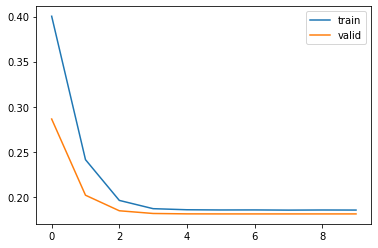

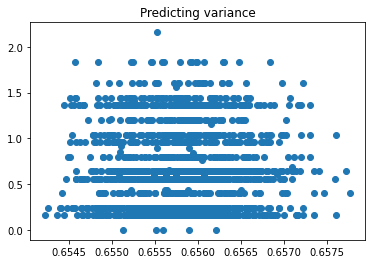

In [ ]:

feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
#train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['meanGrade'])
train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['variance'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))
####Shuffle might need to be true. Check later
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


train_losses, valid_losses, preds, targs = train(train_loader, dev_loader, model, epochs)
plot(train_losses, valid_losses, len(train_losses))
plt.scatter(preds, targs)
plt.title("Predicting variance")
plt.show()


### Predicting the mean with all data


Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.41 | Train MSE: 0.41 | Train RMSE: 0.64 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 02 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 03 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 04 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 05 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.59 |
| Epoch: 06 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.59 |
| Epoch: 07 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.59 |
| Epoch: 08 | Train Loss: 0.35 | Train 

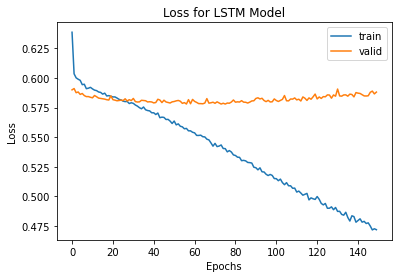

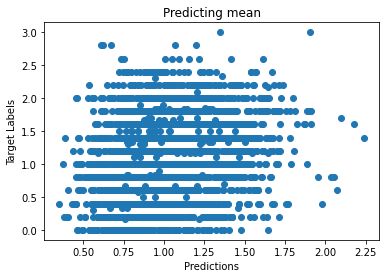

In [24]:

feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['meanGrade'])
#train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['variance'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))
####Shuffle might need to be true. Check later
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.8)


train_losses, valid_losses, preds, targs, train_rmses, valid_rmses = train(train_loader, dev_loader, model, 80)
plt.title("Loss for LSTM Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plot(train_rmses, valid_rmses, len(train_rmses))
plt.scatter(preds, targs)
plt.title("Predicting mean")
plt.xlabel("Predictions")
plt.ylabel("Target Labels")
plt.show()


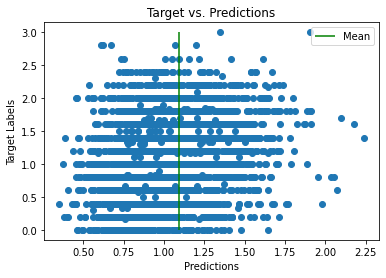

In [25]:
plt.scatter(preds, targs)
mean = np.mean(train_df["meanGrade"].tolist())
plt.title("Target vs. Predictions")
plt.vlines(mean, ymin = 0, ymax = 3, label="Mean", color = "green")
plt.legend()
plt.xlabel("Predictions")
plt.ylabel("Target Labels")
plt.show()


### Predicting the mean with high variance data

In [ ]:
train_df

,id,original,edit,grades,meanGrade,old,edited,variance
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,Isis,France is ‘ hunting down its citizens who join...,0.16
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,Syria,"Pentagon claims 2,000 % increase in Russian tr...",1.44
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Coalition,Iceland PM Calls Snap Vote as Pedophile Furor ...,0.80
3,76,"In an apparent first , Iran and Israel engage ...",slap,20000,0.4,engage,"In an apparent first , Iran and Israel slap ea...",0.64
4,8832,All 22 promises Trump made in his speech to Co...,sounds,22200,1.2,promises,All 22 sounds Trump made in his speech to Cong...,0.96
...,...,...,...,...,...,...,...,...
9124,12770,"Among Republicans , Trump is more popular than...",interns,21100,0.8,leaders,"Among Republicans , Trump is more popular than...",0.56
9125,1781,Protesters Rally for Refugees Detained at JFK ...,stewardesses,20000,0.4,Refugees,Protesters Rally for stewardesses Detained at ...,0.64
9126,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6,marriage,Cruise line Carnival Corp. joins the fight aga...,0.64
9127,14483,Columbia police hunt woman seen with gun near ...,cake,32200,1.4,gun,Columbia police hunt woman seen with cake near...,1.44


In [ ]:
indexNames = train_df[(train_df['variance'] < 0.3)].index
# Delete these row indexes from dataFrame
high_v_train = train_df.drop(indexNames, inplace=False)
high_v_train = high_v_train.reset_index(inplace=False,drop=True)

In [ ]:
high_v_train

,id,original,edit,grades,meanGrade,old,edited,variance
0,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,Syria,"Pentagon claims 2,000 % increase in Russian tr...",1.44
1,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Coalition,Iceland PM Calls Snap Vote as Pedophile Furor ...,0.80
2,76,"In an apparent first , Iran and Israel engage ...",slap,20000,0.4,engage,"In an apparent first , Iran and Israel slap ea...",0.64
3,8832,All 22 promises Trump made in his speech to Co...,sounds,22200,1.2,promises,All 22 sounds Trump made in his speech to Cong...,0.96
4,12174,New DOJ alert system will flag crimes against ...,laughter,32100,1.2,crimes,New DOJ alert system will flag laughter agains...,1.36
...,...,...,...,...,...,...,...,...
6297,7544,This Is What Happens When You Let Trump Be Trump,orange,33211,2.0,Trump,This Is What Happens When You Let Trump Be ora...,0.80
6298,12770,"Among Republicans , Trump is more popular than...",interns,21100,0.8,leaders,"Among Republicans , Trump is more popular than...",0.56
6299,1781,Protesters Rally for Refugees Detained at JFK ...,stewardesses,20000,0.4,Refugees,Protesters Rally for stewardesses Detained at ...,0.64
6300,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6,marriage,Cruise line Carnival Corp. joins the fight aga...,0.64


Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 1.03 | Train MSE: 1.03 | Train RMSE: 1.01 |         Val. Loss: 0.77 | Val. MSE: 0.77 |  Val. RMSE: 0.88 |
| Epoch: 02 | Train Loss: 0.56 | Train MSE: 0.56 | Train RMSE: 0.75 |         Val. Loss: 0.40 | Val. MSE: 0.40 |  Val. RMSE: 0.63 |
| Epoch: 03 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.56 |         Val. Loss: 0.26 | Val. MSE: 0.26 |  Val. RMSE: 0.51 |
| Epoch: 04 | Train Loss: 0.25 | Train MSE: 0.25 | Train RMSE: 0.50 |         Val. Loss: 0.23 | Val. MSE: 0.23 |  Val. RMSE: 0.48 |
| Epoch: 05 | Train Loss: 0.23 | Train MSE: 0.23 | Train RMSE: 0.48 |         Val. Loss: 0.22 | Val. MSE: 0.22 |  Val. RMSE: 0.47 |
| Epoch: 06 | Train Loss: 0.23 | Train MSE: 0.23 | Train RMSE: 0.48 |         Val. Loss: 0.22 | Val. MSE: 0.22 |  Val. RMSE: 0.47 |
| Epoch: 07 | Train Loss: 0.23 | Train MSE: 0.23 | Train RMSE: 0.48 |         Val. Loss: 0.22 | Val. MSE: 0.22 |  Val. RMSE: 0.47 |
| Epoch: 08 | Train Loss: 0.23 | Train 

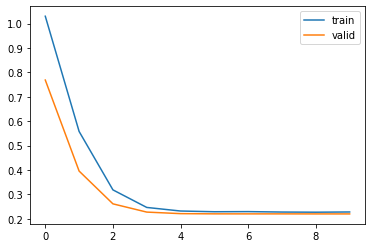

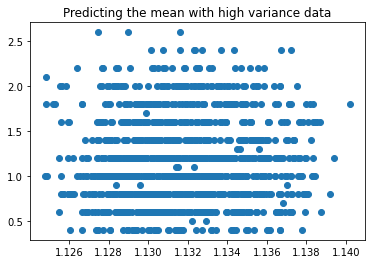

In [ ]:

feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset_double(feature_1,feature_2, high_v_train['meanGrade'])
#train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['variance'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))
####Shuffle might need to be true. Check later
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


train_losses, valid_losses, preds, targs = train(train_loader, dev_loader, model, epochs)
plot(train_losses, valid_losses, len(train_losses))
plt.scatter(preds, targs)
plt.title("Predicting the mean with high variance data")
plt.show()


### Predicting the mean with low variance data

In [ ]:
indexNames = train_df[(train_df['variance'] > 1)].index
# Delete these row indexes from dataFrame
low_v_train = train_df.drop(indexNames, inplace=False)
low_v_train = low_v_train.reset_index(inplace=False,drop=True)

Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.99 | Train MSE: 0.99 | Train RMSE: 0.99 |         Val. Loss: 0.46 | Val. MSE: 0.46 |  Val. RMSE: 0.68 |
| Epoch: 02 | Train Loss: 0.39 | Train MSE: 0.39 | Train RMSE: 0.63 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.60 |
| Epoch: 03 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 04 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 05 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 06 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 07 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 08 | Train Loss: 0.36 | Train 

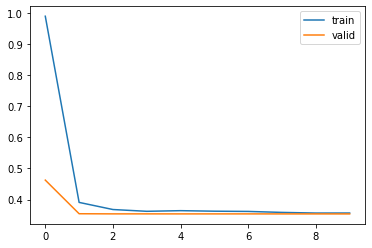

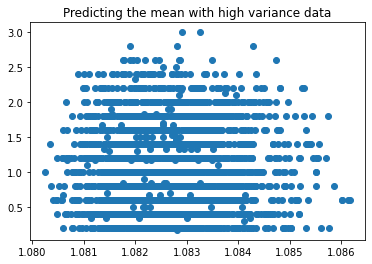

In [ ]:

feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset_double(feature_1,feature_2, low_v_train['meanGrade'])
#train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['variance'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))
####Shuffle might need to be true. Check later
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


train_losses, valid_losses, preds, targs = train(train_loader, dev_loader, model, epochs)
plot(train_losses, valid_losses, len(train_losses))
plt.scatter(preds, targs)
plt.title("Predicting the mean with high variance data")
plt.show()


In [ ]:
model.eval()
predictions_plot = []  
target_plot = []

with torch.no_grad():
    for batch in dev_loader:
        feature, target = batch
        feature_1= feature[0].to(device)
        feature_2 = feature[1].to(device)
        target = target.to(device)

        feature = (feature_1, feature_2)

        # for RNN:
        model.batch_size = target.shape[0]
        model.hidden_1 = model.init_hidden()
        model.hidden_2 = model.init_hidden()

        predictions = model(feature).squeeze(1)

        predictions_plot.append(predictions.detach().cpu().numpy())
        target_plot.append(target.detach().cpu().numpy())


In [ ]:
#plt.scatter(np.flatten(predictions_plot), np.flatten(target_plot))
pred = np.concatenate(predictions_plot, axis=0)
trg = np.concatenate(target_plot, axis=0)

In [ ]:
plt.scatter(pred,trg)
plt.axis('equal')

NameError: ignored

# BERT VERSION

## Bert Preprocessing

In [26]:
def data_to_list(data, training = True):  
  og_headline_list = data['original'].tolist()
  edited_headline_list = data['edited'].tolist()
  edited_word_list = data['edit'].tolist()
  labels_list = None
  if training:
    labels_list = data['meanGrade'].tolist()
  

  return og_headline_list, edited_headline_list, edited_word_list, labels_list

In [27]:
train_og_headlines, train_edited_headlines, train_edited_words, labels = data_to_list(train_df)
test_og_headlines, test_edited_headlines, test_edited_words, _ = data_to_list(test_df, training=False)

In [28]:
def preprocessing(data_list):
  preprocessed_data = []

  for sentence in data_list:

    sentence = re.sub(r'[^\w\s\?\!]', '', sentence)
    sentence = sentence.lower()
    preprocessed_data.append(sentence)
    
  return preprocessed_data

train_og_headlines_p = preprocessing(train_og_headlines)
train_edited_headlines_p = preprocessing(train_edited_headlines)
train_edited_words_p = preprocessing(train_edited_words)

test_og_headlines_p = preprocessing(test_og_headlines)
test_edited_headlines_p = preprocessing(test_edited_headlines)
test_edited_words_p = preprocessing(test_edited_words)

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# the version that concatenates original sentences and new sentences
train_encoded_inputs = tokenizer(train_og_headlines_p, train_edited_headlines_p, padding='max_length', max_length=90, truncation=True, return_tensors="pt")
test_encoded_inputs = tokenizer(test_og_headlines_p, test_edited_headlines_p, padding='max_length', max_length=90, truncation=True, return_tensors="pt")

In [30]:
train_input_ids = train_encoded_inputs['input_ids']
train_attention_mask = train_encoded_inputs['attention_mask']
train_token_type_ids = train_encoded_inputs['token_type_ids']
train_labels = torch.tensor(labels)

train_token_type_ids[0]
tokenizer.decode(train_input_ids.tolist()[1])

'[CLS] pentagon claims 2000 increase in russian trolls after syria strikes what does that mean? [SEP] pentagon claims 2000 increase in russian trolls after bowling strikes what does that mean? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

## Bert Training/Eval


In [31]:
#Hyperparameters
train_proportion = 0.8
batch_size = 16
lr = 5e-5
eps = 1e-8
epochs = 2

In [32]:
class BERT_Dataset(torch.utils.data.Dataset):
    def __init__(self, x1, x2, x3, y1):
        self.len = x1.shape[0]

        self.x1_data = x1.to(device)
        self.x2_data = x2.to(device)
        self.x3_data = x3.to(device)
        self.y1_data = y1.to(device)


    def __getitem__(self, index):
        return self.x1_data[index], self.x2_data[index], self.x3_data[index], self.y1_data[index]


    def __len__(self):
        return self.len

In [33]:


train_and_dev = BERT_Dataset(train_input_ids, train_attention_mask, train_token_type_ids, train_labels)
train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,(train_examples,dev_examples))


train_iter = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )


eval_iter = DataLoader(
            dev_dataset, 
            sampler = SequentialSampler(dev_dataset), # Pull out batches sequentially.
            batch_size = batch_size 
        )

In [48]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # the 12-layer BERT model, with an uncased vocab.
    num_labels = 1,  
    output_attentions = False, # don't return attention weights or hidden states
    output_hidden_states = False, 
)
model.cuda()
#store double values
model = model.double()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [49]:
optimizer = AdamW(model.parameters(), lr = lr, eps = eps)

total_steps = len(train_iter) * epochs
# The scheduler can actually learn the best learning rate throughout tranining
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [46]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    train_losses = np.zeros(number_epoch)
    valid_losses = np.zeros(number_epoch)
    rmses = np.zeros(number_epoch)
    print("Training model.")


    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        epoch_mse = 0
        no_observations = 0  # Observations used for training so far

        for input_ids_batch, attention_mask_batch, token_type_ids_batch, target in train_iter:
            optimizer.zero_grad()

            # get the output
            outputs = model(input_ids_batch,
                            attention_mask=attention_mask_batch,
                            token_type_ids=token_type_ids_batch)
            
            
            predictions = outputs[0].squeeze(1)
            loss = torch.sqrt(((predictions - target)**2).mean())
           # loss, predictions = outputs[:2] 

            no_observations = no_observations + target.shape[0]
         
            sse, mse, _ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy()) 
            
            loss.backward()
            optimizer.step()
            #Update the learning rate.
            scheduler.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse 
            epoch_mse += mse * target.shape[0]

        valid_loss, valid_mse, preds, targs = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_mse / no_observations

        train_losses[epoch-1] = epoch_loss
        valid_losses[epoch-1] = valid_loss
        rmses[epoch-1] = np.sqrt(epoch_mse)
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {np.sqrt(epoch_mse):.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {np.sqrt(valid_mse):.2f} |')
    return train_losses, valid_losses, rmses, preds, targs

In [37]:
from sklearn.metrics import mean_squared_error
# We evaluate performance on our dev set
def eval(dev_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    epoch_mse = 0
    pred_all = []
    trg_all = []
    no_observations = 0
    total_eval_loss = 0


    with torch.no_grad():
        for input_ids_batch, attention_mask_batch, token_type_ids_batch, target in dev_iter:

            no_observations = no_observations + target.shape[0]

            outputs = model(input_ids_batch,
                            attention_mask=attention_mask_batch,
                            token_type_ids=token_type_ids_batch)
            
            #loss, predictions = outputs[:2] 
            predictions = outputs[0].squeeze(1)
            loss = torch.sqrt(((predictions - target)**2).mean())
 
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, mse, rmse = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            epoch_mse += mse*target.shape[0]
            pred_all.extend(pred)
            trg_all.extend(trg)
    

    return epoch_loss/no_observations, epoch_mse/no_observations, np.array(pred_all), np.array(trg_all)

In [38]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse, rmse

In [39]:
def calculate_rmse(predictions, labels):
    loss = torch.sqrt(((predictions - labels)**2).mean())

    return loss

In [43]:
import matplotlib.pyplot as plt
def plot(num_epochs, train_rmses, valid_rmses):
  epochs = list(range(num_epochs))
  plt.plot(epochs,train_rmses, label='train')
  plt.plot(epochs,valid_rmses, label='valid')
  plt.legend()
  plt.title("BERT Loss Curve")
  plt.xlabel("Epochs")
  plt.ylabel("RMSE Loss")
  plt.show()

In [50]:
# Set the seed value all over the place to make this reproducible.
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True

train_losses, valid_losses, rmses, preds, targs= train(train_iter, eval_iter, model, epochs)
 

Training model.
| Epoch: 01 | Train Loss: 0.58 | Train MSE: 0.34 | Train RMSE: 0.59 |         Val. Loss: 0.53 | Val. MSE: 0.28 |  Val. RMSE: 0.53 |
| Epoch: 02 | Train Loss: 0.46 | Train MSE: 0.22 | Train RMSE: 0.47 |         Val. Loss: 0.52 | Val. MSE: 0.28 |  Val. RMSE: 0.53 |


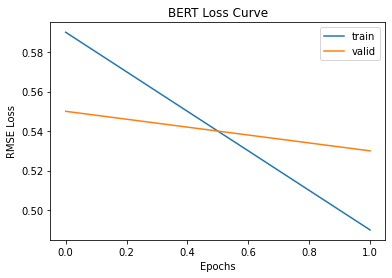

In [44]:
plot(2, [0.59,0.49], [0.55,0.53])


1.087227701929302


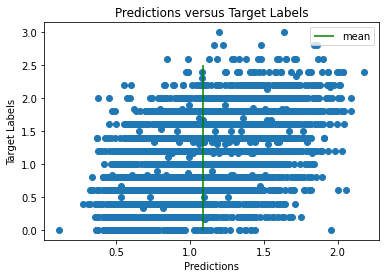

In [51]:
plt.scatter(preds,targs)
plt.title("Predictions versus Target Labels")
plt.xlabel("Predictions")
plt.ylabel("Target Labels")
mean = np.mean(train_df["meanGrade"].tolist())
plt.vlines(mean, ymin = 0, ymax = 2.5, color = 'green', label = "mean")
plt.legend()
print(np.max(preds) - mean)


# Approach 2: No pre-trained representations

## Building a word embedding - Gutenberg

In [ ]:
#Setup
nlp = spacy.load("en")
#GUTENBERG_DIR = "/content/drive/MyDrive/Colab Notebooks/NLP_Coursework/ic_nlp_cw/gutenberg"
#Consti
GUTENBERG_DIR = "/content/drive/MyDrive/Imperial_College/NLP_CW/ic_nlp_cw/gutenberg"

#Kevin
#%cd /content/drive/MyDrive/Colab Notebooks/NLP_Coursework/ic_nlp_cw
#train_df = pd.read_csv('./task-1/train.csv')
#test_df = pd.read_csv('./task-1/dev.csv')
#extra_train = pd.read_csv('./extra_train_data-3.csv')

lemma = True
stemming = False

wordnet_lemmatizer = WordNetLemmatizer()



%pwd

'/content'

In [ ]:
#Preprocess headlines
train_df['old'] = train_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)
train_df['original'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], x['old']) ,axis=1)

train_embedding_df, dev_embedding_df = train_test_split(train_df, test_size=0.2)

In [ ]:
#Using 18 books Gutenberg Corpus
gutenberg_books = []
for i, book_name in enumerate(os.listdir(GUTENBERG_DIR)):
    book_file = open(os.path.join(
        GUTENBERG_DIR, book_name), encoding="latin-1")
    book = book_file.read()
    gutenberg_books.append(book)
    book_file.close()
    #if i == 1:
    #    break

gutenberg_book_lines = []
for book in gutenberg_books:
    book_lines = book.split("\n")
    book_lines = list(filter(lambda x: x != "", book_lines))
    #print(book_lines)
    gutenberg_book_lines.append(book_lines)
    
print(gutenberg_book_lines[:5])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#Takes Gutenberg books an tokenizes corpus
#WARNING: Takes forever
tokenized_corpus = []
for book_line in tqdm(gutenberg_book_lines):
    for line in book_line:
        doc = nlp(line)
        tokenized_corpus.append([token.text.lower() for token in doc if not token.is_punct])
print(tokenized_corpus[:3])

#Use pickle to save corpus to disk
pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg.pkl", "wb"))


100%|██████████| 19/19 [29:41<00:00, 93.75s/it]


[['the', 'tragedie', 'of', 'macbeth', 'by', 'william', 'shakespeare', '1603'], ['actus', 'primus', 'scoena', 'prima'], ['thunder', 'and', 'lightning', 'enter', 'three', 'witches']]


In [ ]:
#Load corpus from disk if previously pickled
tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg.pkl", "rb"))

In [ ]:
#Remove stopwords from corpus
spacy_stop_words = spacy.lang.en.stop_words.STOP_WORDS
stemmer = PorterStemmer()

tokenized_corpus_rmSW = []
for sentence in tqdm(tokenized_corpus):
  if stemming:
    tokenized_corpus_rmSW.append([stemmer.stem(token) for token in sentence if token not in spacy_stop_words])
  elif lemma:
    tokenized_corpus_rmSW.append([wordnet_lemmatizer.lemmatize(token) for token in sentence if token not in spacy_stop_words])
  else: 
    tokenized_corpus_rmSW.append([token for token in sentence if token not in spacy_stop_words])
tokenized_corpus = tokenized_corpus_rmSW
print(tokenized_corpus[:3])
print(len(tokenized_corpus))

if stemming:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_SW_stemmed.pkl", "wb"))
elif lemma:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_SW_lemma.pkl", "wb"))
else:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_SW.pkl", "wb"))

100%|██████████| 206631/206631 [00:06<00:00, 32776.80it/s]


[['tragedie', 'macbeth', 'william', 'shakespeare', '1603'], ['actus', 'primus', 'scoena', 'prima'], ['thunder', 'lightning', 'enter', 'witch']]
206631


In [ ]:
#Remove stop words from Headlines
spacy_stop_words = spacy.lang.en.stop_words.STOP_WORDS

tokenized_headlines = []
for headline in tqdm(train_embedding_df.original):

  tokenized_sentence = []
  doc = nlp(headline)
  for token in doc:
    if token.text not in spacy_stop_words and not token.is_punct:

      if stemming:
        tokenized_sentence.append(stemmer.stem(token.text.lower()))
      elif lemma:
        tokenized_sentence.append(wordnet_lemmatizer.lemmatize(token.text.lower())) 
      else:
        tokenized_sentence.append(token.text.lower())
  tokenized_headlines.append(tokenized_sentence)
print(len(tokenized_headlines))
print(tokenized_headlines[:3])

if stemming:
  pickle.dump(tokenized_headlines, open("tokenized_corpus_headlines_stemmed.pkl", "wb"))
elif lemma:
  pickle.dump(tokenized_headlines, open("tokenized_corpus_headlines_lemma.pkl", "wb"))
else:
  pickle.dump(tokenized_headlines, open("tokenized_corpus_headlines.pkl", "wb"))

100%|██████████| 7721/7721 [01:10<00:00, 109.29it/s]

7721
[['straight', 'stupid', 'incompetent', 'misguided', 'economist', 'adam', 'posen', 'rip', 'trump', 'tariff'], ['trump', 'voter', 'flaw', 'stand', 'president', 'shake', 'thing'], ['trump', 'latest', 'surprise', 'shutdown', 'might', 'be', 'good', 'idea']]


In [ ]:
#add edit words --> adding new word so it is not unknown
#Leave this out -> network would otherwise learn that edit is part of the embedding
edit_corpus = []
for word in tqdm(train_embedding_df.edit):
    doc = nlp(word)
    if stemming:
      edit_corpus.append(stemmer.stem(doc.text.lower())) 
    elif lemma:
      edit_corpus.append(wordnet_lemmatizer.lemmatize(doc.text.lower())) 
    else:
      edit_corpus.append(doc.text.lower())

if stemming:
  pickle.dump(edit_corpus, open("tokenized_edit_corpus_stemmed.pkl", "wb"))
elif lemma:
  pickle.dump(edit_corpus, open("tokenized_edit_corpus_lemma.pkl", "wb"))
else:
  pickle.dump(edit_corpus, open("tokenized_edit_corpus.pkl", "wb"))

100%|██████████| 7721/7721 [00:55<00:00, 138.54it/s]


In [ ]:
if stemming:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_SW_stemmed.pkl", "rb"))
  tokenized_headlines = pickle.load(open("tokenized_corpus_headlines_stemmed.pkl", "rb"))
  edit_corpus = pickle.load(open("tokenized_edit_corpus_stemmed.pkl", "rb"))
elif lemma:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_SW_lemma.pkl", "rb"))
  tokenized_headlines = pickle.load(open("tokenized_corpus_headlines_lemma.pkl", "rb"))
  edit_corpus = pickle.load(open("tokenized_edit_corpus_lemma.pkl", "rb"))

else:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_SW.pkl", "rb"))
  tokenized_headlines = pickle.load(open("tokenized_corpus_headlines.pkl", "rb"))
  edit_corpus = pickle.load(open("tokenized_edit_corpus.pkl", "rb"))

print(len(tokenized_corpus))
print(len(tokenized_headlines))

206631
7721


In [ ]:
#Combine corpus
tokenized_corpus = tokenized_corpus + tokenized_headlines #+  edit_corpus

In [ ]:
#Save full corpus
if stemming:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_full_stemmed.pkl", "wb"))
elif lemma:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_full_lemma.pkl", "wb"))
else:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_full.pkl", "wb"))

In [ ]:
#Load full corpus from pickle
if stemming:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_full_stemmed.pkl", "rb"))
elif lemma:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_full_lemma.pkl", "rb"))
else:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_full.pkl", "rb"))

In [ ]:
#add special token for BILSTM
for i in range(5):
  tokenized_corpus.append('???')
    
pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg.pkl", "wb"))


In [ ]:
train_df

,id,original,edit,grades,meanGrade,old
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,Isis
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,Syria
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Coalition
3,76,"In an apparent first , Iran and Israel engage ...",slap,20000,0.4,engage
4,6164,Trump was told weeks ago that Flynn misled Vic...,school,0,0.0,Vice
...,...,...,...,...,...,...
9647,10899,State officials blast ' unprecedented ' DHS mo...,idea,0,0.0,move
9648,1781,Protesters Rally for Refugees Detained at JFK ...,stewardesses,20000,0.4,Refugees
9649,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6,marriage
9650,14483,Columbia police hunt woman seen with gun near ...,cake,32200,1.4,gun


In [ ]:
#maybe change cut off frequency (all words less than cutoff not relevant -> too many unknowns in this case)
def get_vocabulary(tokenized_corpus, cutoff_frequency=1):
    vocab_freq_dict = dict()
    for sentence in tokenized_corpus:
        for token in sentence:

            if token not in vocab_freq_dict.keys():
                vocab_freq_dict[token] = 0

            vocab_freq_dict[token] += 1

    vocabulary = set()
    for sentence in tokenized_corpus:
        for token in sentence:

            if vocab_freq_dict[token] > cutoff_frequency:
                vocabulary.add(token)
                
    return vocabulary

vocabulary = get_vocabulary(tokenized_corpus)
print("LENGTH OF VOCAB:", len(vocabulary), "\nVOCAB:", vocabulary)
#No stemming or lemmatization, just punc removal
#Before stop word removal 32670
#With stop words removal 32393

LENGTH OF VOCAB: 28926 
VOCAB: {'shell', 'goal', '1:30', 'ruinationed', 'cordial', 'zeresh', 'tumultuously', 'tree', 'cartload', 'omnivorous', 'omg', 'dislike', 'combatting', 'noun', '24:38', 'belched', 'command', 'twain', 'emulate', 'matin', 'outlaw', 'dreg', 'blows!--there', '41:28', 'chelsea', 'charade', 'sailor', "pull'd", 'propped', 'omar', '30:14', 'salma', '25:22', 'impartially', '14:35', 'nigger', "undimm'd", 'address', 'chamberlain', 'fleecy', 'evident', 'weaken', 'insidious', 'assai', 'ludim', 'azotus', 'gambolled', '13:6', 'earth', 'wondrous', 'slung', 'maxine', 'campaign', 'waited', 'chapter', 'rat', 'stare', 'townsend', 'darkon', 'sufficed', 'thyatira', 'anointed', 'gittite', 'witnesse', 'restricted', 'dung', 'playfully', 'chaotic', 'prettiest', 'chastity', 'genially', 'jaffa', 'collection', 'age', 'lamplight', 'dusk', 'tumbled', 'spouter', '25:29', 'insolence', 'evolving', 'snowden', 'wrist', 'anti', 'rudiment', 'topaz', 'overall', '35:7', 'metellus', 'bequest', 'transcen

In [ ]:
OOV_token = "<OOV>" #Adding unknow token
vocabulary.add(OOV_token)
word2idx = {}
n_words = 0

#Replace all tokens not in vocabulary with unknow token
tokenized_corpus_with_OOV = []
for sentence in tokenized_corpus:

    tokenized_sentence_with_OOV = []
    for token in sentence:
        if token in vocabulary:
            tokenized_sentence_with_OOV.append(token)
        else:
            tokenized_sentence_with_OOV.append(OOV_token)
    tokenized_corpus_with_OOV.append(tokenized_sentence_with_OOV)

In [ ]:
for token in vocabulary:
    if token not in word2idx:
        word2idx[token] = n_words
        n_words += 1

assert len(word2idx) == len(vocabulary)

# Invert dictionary
idx2word = {idx: word for word, idx in word2idx.items()}

assert len(idx2word) == len(word2idx)

In [ ]:

def get_focus_context_pairs(tokenized_corpus, window_size=3):
    focus_context_pairs = []
    for sentence in tokenized_corpus:

        for token_idx, token in enumerate(sentence):

            for w in range(-window_size, window_size+1):
                context_word_pos = token_idx + w

                if w == 0 or context_word_pos >= len(sentence) or context_word_pos < 0:
                    continue

                try:
                    focus_context_pairs.append([token, sentence[context_word_pos]])
                except:
                    continue
    
    return focus_context_pairs
focus_context_pairs = get_focus_context_pairs(tokenized_corpus_with_OOV)

print(focus_context_pairs[0:40])

[['tragedie', 'macbeth'], ['tragedie', 'william'], ['tragedie', 'shakespeare'], ['macbeth', 'tragedie'], ['macbeth', 'william'], ['macbeth', 'shakespeare'], ['macbeth', '<OOV>'], ['william', 'tragedie'], ['william', 'macbeth'], ['william', 'shakespeare'], ['william', '<OOV>'], ['shakespeare', 'tragedie'], ['shakespeare', 'macbeth'], ['shakespeare', 'william'], ['shakespeare', '<OOV>'], ['<OOV>', 'macbeth'], ['<OOV>', 'william'], ['<OOV>', 'shakespeare'], ['actus', 'primus'], ['actus', 'scoena'], ['actus', 'prima'], ['primus', 'actus'], ['primus', 'scoena'], ['primus', 'prima'], ['scoena', 'actus'], ['scoena', 'primus'], ['scoena', 'prima'], ['prima', 'actus'], ['prima', 'primus'], ['prima', 'scoena'], ['thunder', 'lightning'], ['thunder', 'enter'], ['thunder', 'witch'], ['lightning', 'thunder'], ['lightning', 'enter'], ['lightning', 'witch'], ['enter', 'thunder'], ['enter', 'lightning'], ['enter', 'witch'], ['witch', 'thunder']]


In [ ]:
def get_focus_context_idx(focus_context_pairs):
    idx_pairs = []
    for pair in focus_context_pairs:
        idx_pairs.append([word2idx[pair[0]], word2idx[pair[1]]])
    
    return idx_pairs


idx_pairs = get_focus_context_idx(focus_context_pairs)

print(idx_pairs[0:20])

[[25913, 22662], [25913, 7783], [25913, 28876], [22662, 25913], [22662, 7783], [22662, 28876], [22662, 3966], [7783, 25913], [7783, 22662], [7783, 28876], [7783, 3966], [28876, 25913], [28876, 22662], [28876, 7783], [28876, 3966], [3966, 22662], [3966, 7783], [3966, 28876], [17345, 20050], [17345, 16250]]


In [ ]:
#Input one hot encoded word and creates embedding (learns as matrix) -> outputs which word follows
class Word2Vec(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim_size):
        super().__init__()
        
        # Why do you think we don't have an activation function here?
        self.projection = nn.Linear(input_size, hidden_dim_size, bias=False)
        self.output = nn.Linear(hidden_dim_size, output_size)
        
    def forward(self, input_token):
        x = self.projection(input_token)
        output = self.output(x)
        return output

In [ ]:
def get_one_hot(indicies, vocab_size=len(vocabulary)):
    oh_matrix = np.zeros((len(indicies), vocab_size))
    for i, idx in enumerate(indicies):
        oh_matrix[i, idx] = 1

    return torch.Tensor(oh_matrix)

In [ ]:
def train(word2vec_model, idx_pairs, state_dict_filename, early_stop=False, num_epochs=15, lr=1e-3):

    word2vec_model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(word2vec_model.parameters(), lr=lr)

    for epoch in range(num_epochs):

        random.shuffle(idx_pairs)

        for focus, context in idx_pairs:
            print(focus)
            oh_inputs = get_one_hot([focus], len(vocabulary))
            target = torch.LongTensor([context])

            pred_outputs = word2vec_model(oh_inputs)

            loss = criterion(pred_outputs, target)

            loss.backward()
            optimizer.step()
            word2vec_model.zero_grad()
            
        ### These lines stop training early
            if early_stop: break
        if early_stop: break
        ###

        torch.save(word2vec_model.state_dict(), state_dict_filename)
        writer.add_embedding(word2vec_model.projection.weight.T,
                             metadata=word2idx.keys(), global_step=epoch)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/word2vec_gutenberg')

In [ ]:
w2v_gutenberg = Word2Vec(len(vocabulary), len(vocabulary), 128)
train(w2v_gutenberg, idx_pairs, "word2vec_gutenberg.pt", early_stop=True)

5380


In [ ]:
weights_matrix = w2v_gutenberg.projection.weight.T #Embedding matrix
print(weights_matrix.shape)

torch.Size([28927, 128])


## Predictions based on cosine distance between replacement words and edit words

In [ ]:
from scipy.spatial.distance import cosine


In [ ]:
if stemming:
  train_embedding_df.old = train_embedding_df.old.map(stemmer.stem)
  train_embedding_df.edit = train_embedding_df.edit.map(stemmer.stem)
  dev_embedding_df.old = dev_embedding_df.old.map(stemmer.stem)
  dev_embedding_df.edit = dev_embedding_df.edit.map(stemmer.stem)
elif lemma:
  train_df.old = train_df.old.map(wordnet_lemmatizer.lemmatize)
  train_df.edit = train_df.edit.map(wordnet_lemmatizer.lemmatize)
  dev_embedding_df.old = dev_embedding_df.old.map(wordnet_lemmatizer.lemmatize)
  dev_embedding_df.edit = dev_embedding_df.edit.map(wordnet_lemmatizer.lemmatize)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
train_embedding_df.old

9449    Economist
7641       things
7261         Idea
1900      created
6738          war
          ...    
4625     diplomat
6612        White
7837        Trump
3250     violence
6686        Offer
Name: old, Length: 7721, dtype: object

In [ ]:
#get idx for old word
old_idx_train = []
for word in train_embedding_df.old.str.lower():
    #that also excludes words that consist of two words. not good
    if word in list(word2idx.keys()):
        old_idx_train.append(word2idx[word])
    else:
        word = OOV_token
        old_idx_train.append(word2idx[word])


old_idx_dev = []
for word in dev_embedding_df.old.str.lower():
    #that also excludes words that consist of two words. not good
    if word in list(word2idx.keys()):
        old_idx_dev.append(word2idx[word])
    else:
        word = OOV_token
        old_idx_dev.append(word2idx[word])



#get idx for edit word
edit_idx_train = []
for word in train_embedding_df.edit.str.lower():
    #that also excludes words that consist of two words. not good
    if word in list(word2idx.keys()):
        edit_idx_train.append(word2idx[word])
    else:
        word = OOV_token
        edit_idx_train.append(word2idx[word])


#get idx for edit word
edit_idx_dev = []
for word in dev_embedding_df.edit.str.lower():
    #that also excludes words that consist of two words. not good
    if word in list(word2idx.keys()):
        edit_idx_dev.append(word2idx[word])
    else:
        word = OOV_token
        edit_idx_dev.append(word2idx[word])




In [ ]:
old_word_embedding_train = get_one_hot(old_idx_train) @ weights_matrix.detach().numpy()
edit_embedding_train = get_one_hot(edit_idx_train) @ weights_matrix.detach().numpy()

old_word_embedding_dev = get_one_hot(old_idx_dev) @ weights_matrix.detach().numpy()
edit_embedding_dev = get_one_hot(edit_idx_dev) @ weights_matrix.detach().numpy()


distances_train = []
distances_dev = []
for i in range(len(old_word_embedding_train)):
    cos_distance_train = cosine(old_word_embedding_train[i], edit_embedding_train[i])
    distances_train.append(cos_distance_train)

for i in range(len(old_word_embedding_dev)):
    cos_distance_dev = cosine(old_word_embedding_dev[i], edit_embedding_dev[i])
    distances_dev.append(cos_distance_dev)
train_embedding_df['cos_distance'] = distances_train
dev_embedding_df['cos_distance'] = distances_dev

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_embedding_df['edit_word_corpus_rep'] = [idx2word[idx] for idx in edit_idx_train]
train_embedding_df['old_word_corpus_rep'] = [idx2word[idx] for idx in old_idx_train]

dev_embedding_df['edit_word_corpus_rep'] = [idx2word[idx] for idx in edit_idx_dev]
dev_embedding_df['old_word_corpus_rep'] = [idx2word[idx] for idx in old_idx_dev]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
train_embedding_df

,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep
9449,7533,"‘ Straight up stupid , ' ' incompetent ' and '...",Bully,11100,0.6,Economist,1.121741,bully,economist
7641,4158,Trump voters see his flaws but stand by presid...,pelvis,21110,1.0,things,0.000000,<OOV>,<OOV>
7261,1950,Trump ’s Latest Surprise : Shutdown Might Be a...,Movie,22211,1.6,Idea,1.104112,movie,idea
1900,1520,Trump loves Civil War memorials so much that h...,remembered,21100,0.8,created,1.030159,remembered,created
6738,6976,China says it will never allow war or chaos on...,snow,31110,1.2,war,0.912631,snow,war
...,...,...,...,...,...,...,...,...,...
4625,10435,Bush-era diplomat tweets that you should be sc...,werewolf,31110,1.2,diplomat,1.088961,<OOV>,diplomat
6612,9401,Trump Invites Rodrigo Duterte to the White House,big,22100,1.0,White,0.802657,big,white
7837,13669,Stocks close lower as Trump says China trade t...,panda,10000,0.2,Trump,0.930827,<OOV>,trump
3250,7937,Trump says the ' alt-left ' bears some respons...,peace,11100,0.6,violence,1.001322,peace,violence


In [ ]:
dev_embedding_df

,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep
5846,8694,One tiny sign of hope : At least Donald Trump ...,personal,21000,0.6,defense,0.906680,personal,defense
2702,13784,Austrian Chancellor may have been one of those...,brewery,11000,0.4,Chancellor,0.955180,brewery,chancellor
6459,12081,Jared Kushner is the Real President,pretzel,22100,1.0,President,1.137658,<OOV>,president
3125,4795,Sea Shepherd claims it caught Japanese fleet w...,urchin,21100,0.8,Shepherd,0.997085,urchin,shepherd
493,2258,"Trump heads overseas , turmoil in his wake",ear,32210,1.6,wake,0.964972,ear,wake
...,...,...,...,...,...,...,...,...,...
771,8635,Tony Blair says UK should launch military acti...,tub,11000,0.4,Syria,0.983676,tub,syria
2082,228,Senate GOP health care bill vote : The whip co...,cream,3221111000,1.1,count,1.014655,cream,count
8068,14054,Stunning details reveal how Israel ’s spy agen...,chicken,10000,0.2,heist,1.035733,chicken,heist
7568,4772,"The evangelical slippery slope , from Ronald R...",soap,22100,1.0,slope,0.937799,soap,slope


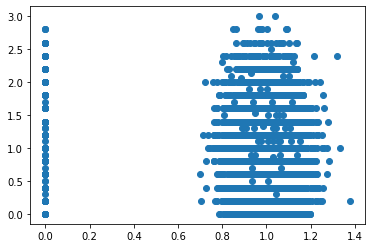

In [ ]:
plt.scatter(train_embedding_df.cos_distance.to_list(), train_embedding_df.meanGrade.to_list())
#Cosine distance where we have double edit

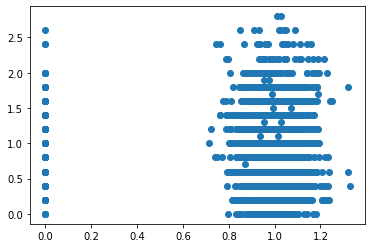

In [ ]:
plt.scatter(dev_embedding_df.cos_distance.to_list(), dev_embedding_df.meanGrade.to_list())

In [ ]:
train_embedding_df.loc[train_embedding_df.cos_distance == 0.0]

,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep


In [ ]:
indexNames = train_embedding_df[(train_embedding_df['cos_distance'] == 0.0)].index
# Delete these row indexes from dataFrame
train_embedding_df.drop(indexNames , inplace=True)
train_embedding_df.reset_index(inplace=True,drop=True)
pd.set_option('display.max_rows', 20)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
indexNames = dev_embedding_df[(dev_embedding_df['cos_distance'] == 0.0)].index
# Delete these row indexes from dataFrame
dev_embedding_df.drop(indexNames , inplace=True)
dev_embedding_df.reset_index(inplace=True,drop=True)
pd.set_option('display.max_rows', 20)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dev_embedding_df.loc[dev_embedding_df.cos_distance == 0.0]

,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep


In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
model = linear_model.LinearRegression()
#train, test = train_test_split(train_df, test_size=0.2)
dist_train = np.reshape(train_embedding_df.cos_distance.to_list(), (-1,1))
dist_test = np.reshape(dev_embedding_df.cos_distance.to_list(), (-1,1))
y = np.reshape(train_embedding_df.meanGrade.to_list(), (-1,1))
y_test = np.reshape(dev_embedding_df.meanGrade.to_list(), (-1,1))
#print(train.cos_distance)

model.fit(dist_train, y)
predictions = model.predict(dist_test)

mean_squared_error(y_test, predictions, squared = False)


0.5801023721713078

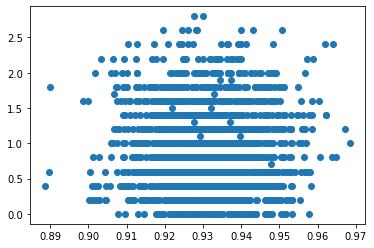

In [ ]:
plt.scatter(predictions,y_test)

In [ ]:
#Only look at headlines where both original word and edited word has an embedding
filt_train_df = train_embedding_df[train_embedding_df['edit_word_corpus_rep'] != '<OOV>'][train_embedding_df['old_word_corpus_rep'] != '<OOV>']
filt_train_df = filt_train_df.reset_index(drop = True)
print(len(filt_train_df))
filt_train_df

3607


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep
0,7533,"‘ Straight up stupid , ' ' incompetent ' and '...",Bully,11100,0.6,Economist,1.121741,bully,economist
1,1950,Trump ’s Latest Surprise : Shutdown Might Be a...,Movie,22211,1.6,Idea,1.104112,movie,idea
2,1520,Trump loves Civil War memorials so much that h...,remembered,21100,0.8,created,1.030159,remembered,created
3,6976,China says it will never allow war or chaos on...,snow,31110,1.2,war,0.912631,snow,war
4,13430,Kanye West under fire after saying slavery was...,water,11000,0.4,fire,1.062934,water,fire
...,...,...,...,...,...,...,...,...,...
3602,13314,Trump Defends Obama 's For-Profit College Crac...,Presidency,22100,1.0,College,0.992828,presidency,college
3603,4076,Lieberman emerges as frontrunner for FBI post,relay,11100,0.6,post,1.051518,relay,post
3604,9401,Trump Invites Rodrigo Duterte to the White House,big,22100,1.0,White,0.802657,big,white
3605,7937,Trump says the ' alt-left ' bears some respons...,peace,11100,0.6,violence,1.001322,peace,violence


In [ ]:
#Only look at headlines where both original word and edited word has an embedding
filt_dev_df = dev_embedding_df[dev_embedding_df['edit_word_corpus_rep'] != '<OOV>'][dev_embedding_df['old_word_corpus_rep'] != '<OOV>']
filt_dev_df = filt_dev_df.reset_index(drop = True)
print(len(filt_dev_df))
filt_dev_df

1190


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep
0,8694,One tiny sign of hope : At least Donald Trump ...,personal,21000,0.6,defense,0.906680,personal,defense
1,13784,Austrian Chancellor may have been one of those...,brewery,11000,0.4,Chancellor,0.955180,brewery,chancellor
2,4795,Sea Shepherd claims it caught Japanese fleet w...,urchin,21100,0.8,Shepherd,0.997085,urchin,shepherd
3,2258,"Trump heads overseas , turmoil in his wake",ear,32210,1.6,wake,0.964972,ear,wake
4,11514,Rep. DeSantis : Shooting Suspect Asked if ‘ Re...,Cake,10000,0.2,Field,0.957824,cake,field
...,...,...,...,...,...,...,...,...,...
1185,8635,Tony Blair says UK should launch military acti...,tub,11000,0.4,Syria,0.983676,tub,syria
1186,228,Senate GOP health care bill vote : The whip co...,cream,3221111000,1.1,count,1.014655,cream,count
1187,14054,Stunning details reveal how Israel ’s spy agen...,chicken,10000,0.2,heist,1.035733,chicken,heist
1188,4772,"The evangelical slippery slope , from Ronald R...",soap,22100,1.0,slope,0.937799,soap,slope


In [ ]:
#Run test only only edited headline where edit was previously seen
model_filt = linear_model.LinearRegression()
#train, test = train_test_split(filt_train_df,test_size = 0.2)
dist_train = np.reshape(filt_train_df.cos_distance.to_list(), (-1,1))
dist_test = np.reshape(filt_dev_df.cos_distance.to_list(), (-1,1))
y = np.reshape(filt_train_df.meanGrade.to_list(), (-1,1))
y_test = np.reshape(filt_dev_df.meanGrade.to_list(), (-1,1))
#print(train.cos_distance)

model.fit(dist_train, y)
predictions = model.predict(dist_test)

mean_squared_error(y_test, predictions, squared = False)

0.5724295258266255

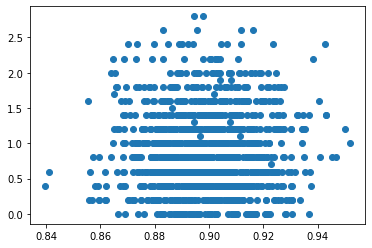

In [ ]:
plt.scatter(predictions,y_test)

## Predictions by BILSTM

In [ ]:
# To create our vocab

def custom_tokenizer(nlp):
    
    replacement_re = re.compile(r'^<*/>') #do not split replacement format
    prefix_re = re.compile(r'''^[\[\("]''')
    suffix_re = re.compile(r''',[\]\)"']$''')
    infix_re = re.compile(r'''[-\,.~]''')
    
    
    return Tokenizer(nlp.vocab,
                     token_match = replacement_re.match,
                     prefix_search=prefix_re.search,
                     suffix_search=suffix_re.search,
                     infix_finditer = infix_re.finditer  
                    )



def preprocessor(data,edits):
    """
    Creating a corpus of all the tokens used
    """
    punctuation = "\":\.,"
    nlp = spacy.load("en_core_web_sm")
    nlp.tokenizer = custom_tokenizer(nlp)
    
    tokenized_corpus_1= [] # Let us put the tokenized corpus in a list
    tokenized_corpus_2= []
    
    
    for i, sentence in enumerate(data):

        sentence = sentence.lower()
        tokenized_sentence_1 = []
        tokenized_sentence_2 = []

        for token in nlp(sentence): # simplest split is

            if token.text in punctuation:
                continue
            else:
                
                if token.text[0] == '<':
                    tokenized_sentence_1.append("???")
                    tokenized_sentence_2.append("???")
                    
                    tokenized_sentence_2.append(edits[i])

                    
                    tokenized_sentence_1.append(token.text[1:-2])
                else:
                    tokenized_sentence_2.append(token.text)
                
                    tokenized_sentence_1.append(token.text)


        tokenized_corpus_1.append(tokenized_sentence_1)
        tokenized_corpus_2.append(tokenized_sentence_2)
        #print(tokenized_corpus_1[:5])
        #print(tokenized_corpus_2[:5])

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus_1:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)
    
    for token in edits:
        
        if token not in vocabulary:
            
            vocabulary.append(token)

    return vocabulary, tokenized_corpus_1, tokenized_corpus_2

In [ ]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = train_df['original']
test_data = test_df['original']

training_vocab, training_tokenized_corpus_1,training_tokenized_corpus_2 =  preprocessor(training_data,train_df['edit'])
test_vocab, test_tokenized_corpus_1,test_tokenized_corpus_2 =  preprocessor(test_data,test_df['edit'])

joint_vocab, joint_tokenized_corpus_1,joint_tokenized_corpus_2 = preprocessor(pd.concat([training_data, test_data]),pd.concat([train_df['edit'],test_df['edit']],ignore_index = True))

print("Vocabulary joined creation - done")



print("Vocab created.")

Vocabulary joined creation - done
Vocab created.


In [ ]:
# We create representations for our tokens
'''
wvecs = [] # word vectors

#Add special character -> embedding vector of ones 
wvecs.append(np.ones(128))

for word in joint_vocab:
    idx = word2idx[word]
    one_hot = get_one_hot([idx])
    wvecs.append8

# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 1 #zero padding
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)


SyntaxError: ignored

In [ ]:


vectorized_seqs_1 = [[word2idx[tok] if tok in word2idx else word2idx[OOV_token] for tok in seq] for seq in training_tokenized_corpus_1]
vectorized_seqs_2 = [[word2idx[tok] if tok in word2idx else word2idx[OOV_token] for tok in seq] for seq in training_tokenized_corpus_2]


# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_1 = [x if len(x) > 0 else [0] for x in vectorized_seqs_1]
vectorized_seqs_2 = [x if len(x) > 0 else [0] for x in vectorized_seqs_2]


In [ ]:
INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 128

BATCH_SIZE = 256

model = BiLSTM_double(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(params)
#print("Total number of parameters is: {​​}​​".format(params))

print(model)

print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
#x = np.concatenate((wvecs,wvecs),axis=1)
model.embedding.weight.data.copy_(weights_matrix)

In [ ]:

feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
#train_and_dev = Task1Dataset(feature, train_df['meanGrade'])
train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))
####Shuffle might need to be true. Check later
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_losses, valid_losses, _,_ = train(train_loader, dev_loader, model, epochs)
plot(train_losses, valid_losses, len(train_losses))

#Without stop words removal 0.6

In [ ]:
#Maybe reduce number of layers

In [ ]:
len(dev_loader)

In [ ]:
model.eval()
predictions_plot = []  
target_plot = []

with torch.no_grad():
    for batch in dev_loader:
        feature, target = batch
        feature_1= feature[0].to(device)
        feature_2 = feature[1].to(device)
        target = target.to(device)

        feature = (feature_1, feature_2)

        # for RNN:
        model.batch_size = target.shape[0]
        model.hidden_1 = model.init_hidden()
        model.hidden_2 = model.init_hidden()

        predictions = model(feature).squeeze(1)

        predictions_plot.append(predictions.detach().cpu().numpy())
        target_plot.append(target.detach().cpu().numpy())


In [ ]:
#plt.scatter(np.flatten(predictions_plot), np.flatten(target_plot))
pred = np.concatenate(predictions_plot, axis=0)
trg = np.concatenate(target_plot, axis=0)

In [ ]:
plt.scatter(pred,trg)
plt.axis('equal')

## Baseline given


In [ ]:
train_and_dev = train_df['edit']
train_proportion = 0.8
training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
transformer
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)
print(train_counts)

  (0, 6912)	0.3196422657133493
  (0, 6889)	0.4635074138381324
  (0, 6423)	0.11278822224285272
  (0, 5804)	0.44285750586411565
  (0, 5374)	0.23652438242454743
  (0, 5312)	0.3400955840429778
  (0, 4309)	0.34740743437045796
  (0, 4089)	0.2845496729305107
  (0, 3299)	0.31761063288602626
  (1, 6541)	0.48194793383580115
  (1, 5549)	0.3204233579379913
  (1, 5014)	0.42370065991381706
  (1, 2759)	0.4595615370435467
  (1, 2464)	0.5237709472831734
  (2, 6892)	0.35794538379097757
  (2, 6156)	0.36483747544305006
  (2, 5741)	0.3829658592421385
  (2, 5499)	0.3419984129026347
  (2, 4801)	0.3829658592421385
  (2, 4305)	0.291413316187634
  (2, 3322)	0.313301064206565
  (2, 2076)	0.3110077361041403
  (2, 1141)	0.2206241510260133
  (3, 6534)	0.39337308644812724
  (3, 6423)	0.09734562388426601
  :	:
  (7717, 6019)	0.520234681094425
  (7717, 5375)	0.28639284053699743
  (7717, 3451)	0.4360369675276321
  (7717, 3299)	0.3331918391659665
  (7717, 2782)	0.46458301954981385
  (7717, 2533)	0.3610437600682453
  (77

In [ ]:
mean = train_df['meanGrade'].mean()
sum = 0
for i in range(len(train_df['meanGrade'])):
    sum += (mean - train_df['meanGrade'].loc[i])**2
np.sqrt(sum / len(train_df['meanGrade']))

0.5836128526966657

In [ ]:

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse, _ = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse, _ = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.16 | RMSE: 0.40 |

Dev performance:
| MSE: 0.48 | RMSE: 0.69 |


In [ ]:
'''
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2) #Needed for LSTMs

        #lstm_out : (seq_len,batch_size,num_directions (2) * hidden_size (50))
        #hidden : (num_layers * num_directions, batch_size,hidden_size)
        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        #out : (1)
        out = self.hidden2label(lstm_out[-1]
        return out

#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)